# HexaDruid: Auto Fix Spark Skew  
Welcome! This notebook will walk you through **HexaDruid**, our PySpark library that:

-  **Automatically detects & corrects** data skew  
-  **Infers schemas** and builds a **DRTree** for logical sharding  
-  **Tunes parameters** (salt count & shuffle partitions)  
-  Is designed to be **noob-friendly**, with plenty of tips  

Let’s get started!

---

# Step 1: Spark Session Configuration

Basic settings and performance tuners for local development.

In [2]:
# Install required Python packages (only if not already installed)
!pip install pyspark>=3.5.1 pandas matplotlib seaborn --quiet
!pip install hexadruid==0.1.6

# Step 2: Import Libraries

Now we bring in:

- 🔧 **HexaDruid** core classes & functions  
- 📊 **pandas** for local DataFrame previews  

> 💡 *Tip:* Make sure you’ve installed your package in editable mode:  
> ```bash
> pip install -e .
> ```

In [3]:
# Step 2: Import Libraries
from pyspark.sql import SparkSession
from hexadruid import HexaDruid
import pandas as pd
import matplotlib.pyplot as plt

ImportError: bad magic number in '_core': b'\xef\xbf\xbd\n'

# Step 3: Spark Session Configuration

In this step we will:

1. **Create** a SparkSession with sensible local defaults  
2. **Apply** performance-tuning configs for development  
3. **Set** log level to WARN to avoid noise  

> 💡 *Tip:* You can adjust `spark_driver_memory` and `spark_executor_memory` based on your machine.

In [ ]:
# ----------------------------
# Spark Session Configuration
# ----------------------------

from pyspark.sql import SparkSession

# Basic Settings
spark_app_name = "HexaDruid_Test"
spark_master = "local[*]"
spark_driver_memory = "2g"
spark_executor_memory = "2g"
spark_log_level = "WARN"

# Performance Tuners
spark_configs = {
    "spark.sql.shuffle.partitions": "4",
    "spark.default.parallelism": "4",
    "spark.sql.adaptive.enabled": "true",
    "spark.sql.adaptive.coalescePartitions.enabled": "true",
    "spark.sql.adaptive.skewJoin.enabled": "true",
    "spark.sql.broadcastTimeout": "60",
    "spark.serializer": "org.apache.spark.serializer.KryoSerializer",
    "spark.sql.codegen.wholeStage": "true",
    "spark.ui.showConsoleProgress": "false",
}

# ----------------------------
# Build Spark Session
# ----------------------------

builder = SparkSession.builder.appName(spark_app_name).master(spark_master)

# Apply memory configs

builder = builder.config("spark.driver.memory", spark_driver_memory)
builder = builder.config("spark.executor.memory", spark_executor_memory)

# Apply performance configs
for k, v in spark_configs.items():
    builder = builder.config(k, v)

# Create Spark session
spark = builder.getOrCreate()

# Set log level
spark.sparkContext.setLogLevel(spark_log_level)

# Confirm Spark details
print(f"Spark v{spark.version} started | Driver: {spark_driver_memory} | Executor: {spark_executor_memory}")

Spark v4.0.0 started | Driver: 2g | Executor: 2g


# Step 3: Define Input Path

**Action:** Update these two variables:

- `input_path`: full path to your data file  
- `file_type`: one of `"csv"`, `"json"`, `"parquet"`, `"delta"`  

This controls how we load the data in Step 4.


In [ ]:
# Replace this path with your own CSV
file_type = "csv"                 # Options: "csv", "json", "parquet", "delta"
input_file = fr"data\garbage_data.{file_type}"

# Step 4: Load Your Data (Any File Type)

We support:

- **`.csv`**: comma-separated values (all columns read as string)  
- **`.json`**: JSON records (multiline or line-delimited)  
- **`.parquet`**: Spark’s columnar format  
- **`.delta`**: Delta Lake tables (optional)  

We’ll **preview** the first 5 rows and print the schema.

In [ ]:
if file_type == "csv":
    df_raw = (
        spark.read
             .option("header", "true")
             .option("inferSchema", "false")  # load all columns as strings
             .csv(input_file)
    )
elif file_type == "json":
    df_raw = spark.read.option("multiLine", "true").json(input_file)
elif file_type == "parquet":
    df_raw = spark.read.parquet(input_file)
elif file_type == "delta":
    df_raw = spark.read.format("delta").load(input_file)
else:
    raise ValueError(f"Unsupported file type: {file_type!r}")

print(f"Loaded {file_type.upper()} data:")
df_raw.show(5, truncate=False)
df_raw.printSchema()

Loaded CSV data:
+------------------------------------+--------+-----+-------------------+
|id                                  |category|value|score              |
+------------------------------------+--------+-----+-------------------+
|9e4ae8ca-afa9-401e-94fa-a52d28002c68|A       |18   |-1.001119469115976 |
|f78bc458-a330-46fa-b290-6cfa207fe8f9|C       |67   |0.8995041356368483 |
|4a30b50a-72c3-4f27-8e29-dea9e5add4fd|D       |1    |-0.5429043041433205|
|8ee96da1-3782-43ba-835d-a7cca1fd630a|A       |35   |1.7987184735669364 |
|eb813a1a-204a-4fb8-bdf2-3ed0039aea44|B       |9    |1.9126727786399833 |
+------------------------------------+--------+-----+-------------------+
only showing top 5 rows
root
 |-- id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- score: string (nullable = true)



# Step 5 (Optional): Infer Schema & Build DRTree

*You can skip this if you already know your schema and don’t need sharding metadata.*

This step:

1. **Samples** a fraction of rows  
   - Controlled by `sample_fraction` (default **20%**).  
   - We “peek” at only part of the data to infer types and build the DRTree quickly, without scanning your entire dataset.

2. **Infers** each column’s type (int, double, string)  
   - Looks at the sampled values to decide if a column should be Integer, Double, or remain String.

3. **Builds** a lightweight **DRTree** for logical data shards  
   - Splits the data into branches based on skewed columns (see below).  
   - The shape of the tree is governed by `max_depth` and `min_samples`.

4. **Casts** the full DataFrame to the inferred schema  
   - Applies the new schema to every row in the original DataFrame.

---

### Parameter Details

- `sample_fraction=0.2`  
  Peek at **20%** of rows for inference (faster + lower memory).

- `max_depth=3`  
  Limit tree depth to **3 splits** (up to 2³ = 8 shards).

- `min_samples=500`  
  Stop splitting any shard with fewer than **500 rows** (avoid tiny shards).

- `skew_thresh=0.1`  
  Only numeric columns with skew score **> 0.10** are used to split.

- `skew_top_n=3`  
  Consider the **top 3** most-skewed numeric columns when building the tree.

---

**Outputs**:

- `df_typed` — your original DataFrame cast to the inferred schema  
- `schema`   — the `StructType` object describing each column  
- `dr_tree`  — metadata (Roots & Branches) defining your logical shards

In [ ]:
do_schema = True  # ← set to False, if you need to skip the Smart Schema Detection!
if do_schema:
    df_typed, schema, dr_tree = HexaDruid.schemaVisor(
        df_raw,
        sample_fraction=0.2,
        max_depth=3,
        min_samples=500,
        skew_thresh=0.1,
        skew_top_n=3
    )
    print("Inferred StructType:\n", schema.json())
    print("DRTree metadata:\n", dr_tree.to_dict())
else:
    df_typed = df_raw
    print("Skipping schemaVisor; proceeding with raw DataFrame.")

Inferred StructType:
 {"fields":[{"metadata":{"avg_length":36.0,"max_length":36},"name":"id","nullable":true,"type":"string"},{"metadata":{"avg_length":1.0,"max_length":1},"name":"category","nullable":true,"type":"string"},{"metadata":{},"name":"value","nullable":true,"type":"integer"},{"metadata":{"avg_length":18.593908629441625,"max_length":21},"name":"score","nullable":true,"type":"string"}],"type":"struct"}
DRTree metadata:
 {'dr_tree': [{'root': 'shard_fallback', 'branches': [{'name': 'shard_fallback', 'predicate': '1=1'}]}]}


# Step 6: Inspect Numeric Columns & Skew Detection

- **Numeric columns**: which fields can be used for skew analysis  
- **Skew detection**: top _N_ columns exceeding the skew threshold  

---

### Skew parameters explained

- **`threshold=0.1`**  
  Only columns whose **skew score** exceeds **0.10 (10%)** will be flagged as skewed.  
  A skew score (based on quartiles) measures how unbalanced the distribution is—higher means more skew.

- **`top_n=3`**  
  Of all the columns that pass the threshold, pick the **top 3** worst-skewed columns for salting.  
  This focuses your effort on the biggest offenders.

> 💡 *Tip:*  
> - If you detect **no** skewed columns, try **lowering** `threshold` (e.g. to `0.05`).  
> - If you want to salt more columns, **increase** `top_n` (e.g. to `5`).  
> - ALWAYS choose the number of columns wisely! **Proceed with extreme caution** (`2` as a default)
> - Make sure to use the output of `Detected skewed columns` in step 8.
>


In [ ]:
# 1) List numeric columns
numeric_cols = HexaDruid.infer_numeric_columns(df_typed)
print("Numeric columns:", numeric_cols)

# 2) Detect skew among them
skew_detector = SkewFeatureDetector(threshold = 0.1, top_n = 2)
skewed = skew_detector.detect(df_typed)

# Make sure you use this in your step (8)
print("Detected skewed columns with indexes:")
for idx, col_name in enumerate(skewed):
    if col_name in skewed:
        print(f"- Index: {idx}, Column: {col_name}")

Numeric columns: ['value']
Detected skewed columns with indexes:
- Index: 0, Column: value


# Step 7: Detect Low-Cardinality Categorical Column

We need a **groupBy** column with few distinct values (≤20), ideal for counting.

- The method picks the **first** such string column.  
- Raises an error if none qualifies.
- The variable `grp_col` is a pointer (a Python string) holding the name of the chosen column. 

> 💡 **Tips for Noobs:**  
> - Verify that `grp_col` makes sense for your analysis—avoid grouping by high-cardinality fields (like user IDs or timestamps) which can reintroduce skew or create too many groups.  
>
> - Override the default anytime by specifying your own column in your code, for example:  
>   ```python
>   df.groupBy("your_column").count()
>   ```  
> - If you see an error, inspect your DataFrame’s string columns to ensure at least one has **20 or fewer** distinct values.  

In [ ]:
grp_col = HexaDruid.detect_low_cardinality_categorical(df_typed)

print("Low-cardinality categorical column:", grp_col)

Low-cardinality categorical column: category


# Step 8: Apply Smart Salting

We will:

1. **Salt** (bucket) the top-skew column into `salt_count` buckets  
2. **Visualize**: z-score, boxplot, histogram (saved to `output_dir`)  
3. **Fine-tune** salt count on 10% sample  
4. **Auto-tune** Spark’s shuffle partitions  

> Outputs a new DataFrame `df_salted`

---

### Parameter breakdown

- **`col_name=top_skew`**  
  The **column name** (string) you want to rebalance.  
  Here `top_skew` comes from your skew detector (`skewed[0]`).

- **`salt_count=10`**  
  Start by slicing your data into **10 buckets** (salt values 0–9).  
  ▶️ *Tip:* Pick a power-of-two or something close to your cluster’s cores.

- **`output_dir="hexa_druid_outputs"`**  
  All visualizations and logs are saved under this folder.  
  ▶️ *Tip:* Make this path unique per dataset or run to avoid overwriting.

- **`visualize=True`**  
  Saves three charts to help you verify the effect:  
  - Z-score comparison (before vs after)  
  - Boxplot (original vs salted)  
  - Histogram with density curves  
  ▶️ *Tip:* If you’re running in a headless environment, these still generate PNG files.

- **`fine_tune=True`**  
  Runs the **AutoParameterTuner** on a **10% sample** of your data to pick a better `salt_count`.  
  It tests the supplied counts (`[10, dp, dp*2]`) and chooses the one minimizing the sum-of-squares of partition sizes.  
  ▶️ *Tip:* Great for beginners—avoid manual trial-and-error.

- **`auto_tune=True`**  
  After salting, adjusts `spark.sql.shuffle.partitions` based on your **`target_rows`**.  
  Ensures partitions are neither too small (wasted overhead) nor too large (OOM risk).

- **`target_rows=1000`**  
  The tuner tries to achieve ~**1,000 rows per partition**.  
  ▶️ *Tip:* Lower for very skewed data or smaller clusters; increase for big clusters.

---

> 💡 **Tips for Noobs:**  
> - **Check your plots!** Open the PNGs under `hexa_druid_outputs/` to visually confirm balance.  
> - If your data is small, **reduce** `target_rows` to keep partitions reasonably sized.  
> - If salting doesn’t help, try **lowering** `skew_thresh` in Step 6 or **increasing** `salt_count`.  
> - Always **version** your `output_dir` (e.g., include a timestamp) to compare different runs.


[INFO] [Tuner] n=10, cost=1127
[INFO] [Tuner] n=4, cost=2647
[INFO] [Tuner] n=8, cost=1547
[INFO] [Tuner] chosen salt_count=10
[INFO] [ShuffleTuner] partitions=1


Salting complete. Plots saved under hexa_druid_outputs/


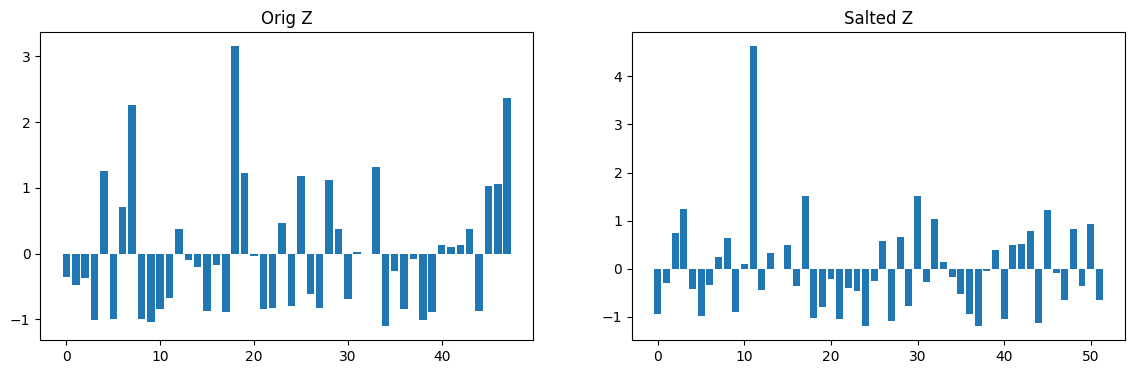

In [ ]:
# Using the output index from Step (6)
top_skew = skewed[0]

hexa = HexaDruid(df_typed, salt_count=10, output_dir="hexa_druid_outputs")
df_salted = hexa.apply_smart_salting(
    col_name=top_skew,
    visualize=True,
    fine_tune=True,
    auto_tune=True,
    target_rows=1000
)
print("Salting complete. Plots saved under hexa_druid_outputs/")

# Step 9: Repartition on Salted Key

(Optional) Force repartition on `"salted_key"` to guarantee even distribution.

- Use `npartitions` equal to your cluster parallelism.

In [ ]:
df_repart = hexa.repartition_on_salt(num_partitions=10)
print("Repartitioned on salted_key")

Repartitioned on salted_key


# Step 10: Show Partition Sizes

Compare record counts per partition **before** vs **after** salting.

- Helps you verify the skew has been mitigated.

In [ ]:
hexa.show_partition_sizes(df_typed, label="Before Salting")
hexa.show_partition_sizes(df_repart, label="After Salting")

[INFO] [Before Salting] sizes=[1000]
[INFO] [After Salting] sizes=[128, 83, 50, 81, 92, 120, 108, 80, 143, 115]


# (OPTIONAL) Step 11: Detect Primary Key Candidate(s) OR Detect Composite Primary Key Candidates

Using your **DRTree** shards, we aggregate:

- **Distinct counts**: how many **unique values** exist per column (or combo)
- **Null counts**: how many **missing values** per column

We compute a **confidence score** for each column or combo:

### Method Used: `hexa.detect_keys()`

This will **first attempt to find a single-column primary key**.  
If none is confidently detected, it will **automatically test combinations of 2–3 columns** for a **composite key**.

### Parameter breakdown

- **`dr_tree: Optional[DRTree] = None`**  

  - A DRTree (Decision Rule Tree) **partitioning the data into logical shards**.  

  - This helps analyze primary key uniqueness **within each branch of the data**, which is often more reliable than analyzing the entire dataset at once.

  - This is the Decision Root Tree that contains filtering predicates per shard.

  - Each "shard" helps break your data down into logical partitions, making the analysis scale-aware and context-sensitive.

  - If not passed, a fallback tree (1=1) is used to treat the entire dataset as one shard.

  ▶️ *Tip:* You get this tree from `schemaVisor()` (Step 5). DRTree is built automatically via HexaDruid.schemaVisor(...)

- **`verbose=True`**  
  Prints out the **distinct ratio, null ratio, and score** per column (or combo).  
  ▶️ *Tip:* Useful to manually verify borderline cases.

---
### 💡 Tips for Beginners

- You **must run `schemaVisor()`** before this step so you have a valid `dr_tree` to pass.
- If your dataset has no unique ID column, try to **combine 2 or 3 categorical columns** (e.g. `order_id`, `product_id`, `region`)—this is what composite key detection does automatically.
- If you get a `KeyError`, make sure the DRTree isn't empty, and that `df_typed` has the expected columns.

---

In [ ]:
key_result = hexa.detect_keys(dr_tree=dr_tree, verbose=True)

if key_result:
    print(f"Detected {key_result['type']} key column(s): {key_result['columns']}, confidence: {key_result['confidence']}")
else:
    print("No confident primary or composite key detected.")

[INFO] id: dr=0.990, null=0.000, score=0.990


Detected primary key column(s): ['id'], confidence: 0.99


# Step 12: Advisor Suggestions

The **AutoParameterAdvisor** shows you:

- A table of **skew** vs **cardinality**  
- Top 3 skew candidates  
- Top 3 groupBy candidates  

You can then pick interactively.

In [ ]:
advisor = AutoParameterAdvisor(df_typed)
skew_cands, cat_cands, metrics_df = advisor.recommend()
print("Pick from:", cat_cands)

# Instead of letting it prompt
df_balanced = HexaDruid(df_typed).apply_smart_salting(col_name=skew_cands[0])
df_balanced.groupBy("category").count().show()

PySparkRuntimeError: [SESSION_OR_CONTEXT_NOT_EXISTS] SparkContext or SparkSession should be created first.

# Step 13: Run Interactive Full Pipeline

One command that:

1. Prompts you to **choose** skew & groupBy columns  
2. Applies **salting**, shows **before/after** timings & partition sizes  

Perfect for demos!


=== Metrics ===
  column    type     skew  cardinality
   value numeric 0.218182          NaN
category  string      NaN          5.0
      id  string      NaN       1000.0
   score  string      NaN       1000.0

Skew → ['value']
GroupBy → ['category', 'id', 'score']


[INFO] [Tuner] n=10, cost=1127
[INFO] [Tuner] n=4, cost=2647
[INFO] [Tuner] n=8, cost=1547
[INFO] [Tuner] chosen salt_count=10
[INFO] [ShuffleTuner] partitions=1
[INFO] [Before] 0.208s


+--------+-----+
|category|count|
+--------+-----+
|       A|  504|
|       C|   95|
|       D|  102|
|       B|  215|
|       E|   84|
+--------+-----+



[INFO] [After] 0.215s


+--------+-----+
|category|count|
+--------+-----+
|       A|  504|
|       C|   95|
|       D|  102|
|       B|  215|
|       E|   84|
+--------+-----+



[INFO] [Before] sizes=[1000]
[INFO] [After] sizes=[1000]


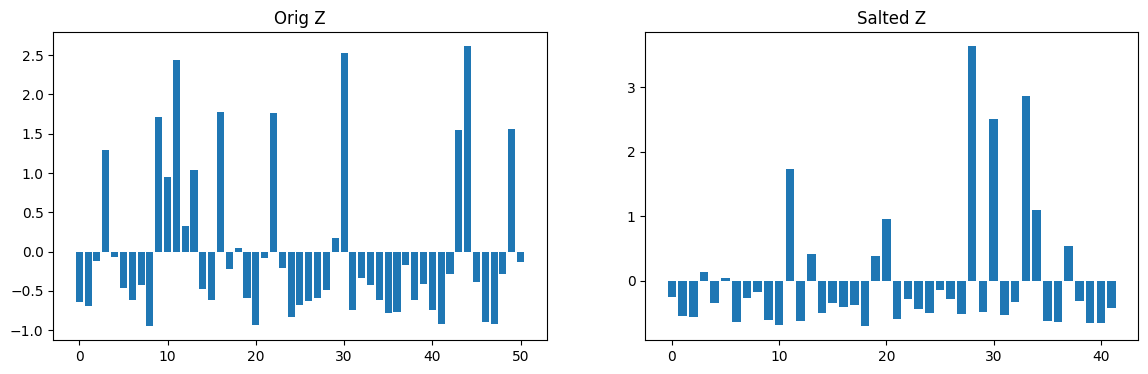

In [ ]:
# df_balanced = balance_skew(df_typed)

# Step 14: Stop Spark Session

Always clean up when done.

In [ ]:
spark.stop()
print("Spark session stopped.")

Spark session stopped.
